In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Reload the naive predictions

Shows how to make use of the data produced from the `scripted` script `naive.py`.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import open_cp.scripted
import open_cp.scripted.analysis as analysis

In [3]:
loaded = open_cp.scripted.Loader("stscan_preds.pic.xz")

In [4]:
loaded.timed_points.time_range

(numpy.datetime64('2016-01-02T13:00:00.000'),
 numpy.datetime64('2017-08-09T09:00:00.000'))

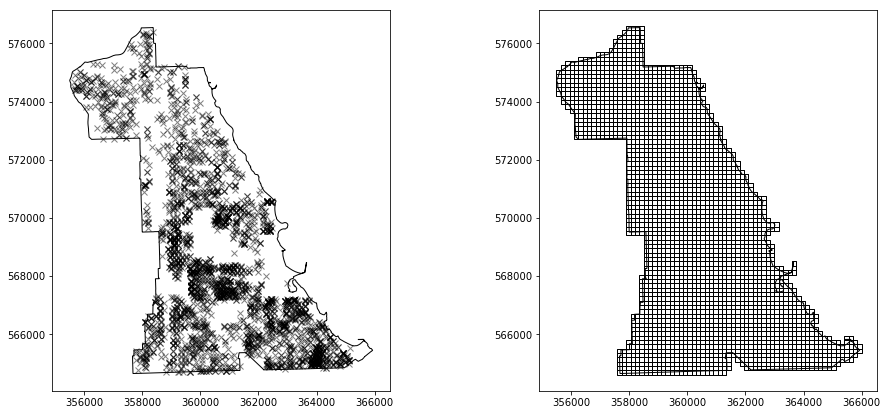

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))
analysis.plot_data_scatter(loaded, axes[0])
analysis.plot_data_grid(loaded, axes[1])

In [6]:
next(iter(loaded))

LoadedPrediction(predictor_class=STScanProvider(r=500, time=21 days, 0:00:00, max=False), time=datetime.datetime(2016, 10, 1, 0, 0), prediction=GridPredictionArray(offset=(355500,564600), size=150x150, risk intensity size=70x80))

In [7]:
times = [x[1] for x in loaded]
preds = [x[2] for x in loaded]

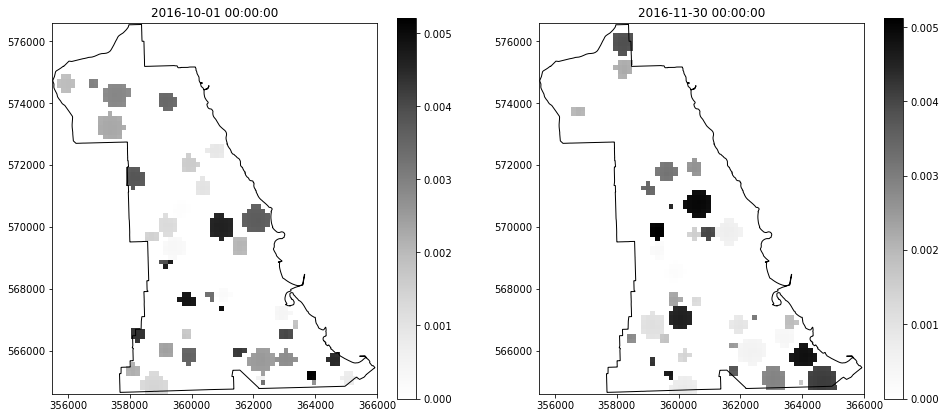

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))
for ax, i in zip(axes, [0, 60]):
    analysis.plot_prediction(loaded, preds[i], ax)
    ax.set_title(times[i])

## Fit binomial model instead

Use a [beta prior](https://en.wikipedia.org/wiki/Conjugate_prior)

In [9]:
betas = analysis.hit_counts_to_beta("stscan_counts.csv")

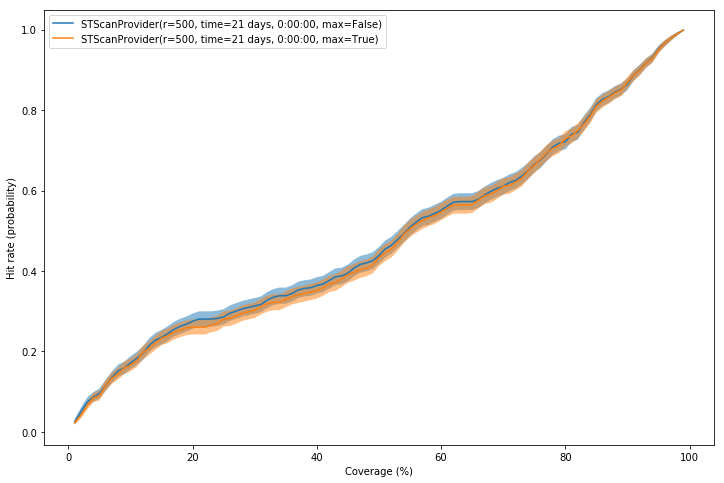

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
analysis.plot_betas(betas, ax)

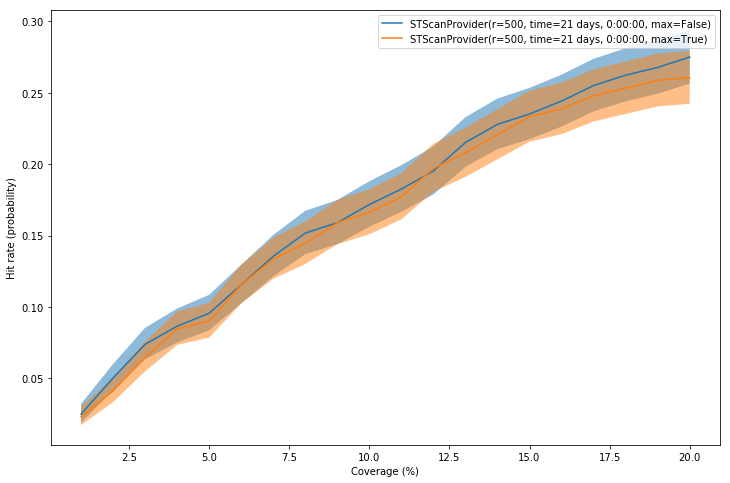

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
analysis.plot_betas(betas, ax, range(1,21))

## What does this difference actually mean??

Suppose we pick 5% coverage. There is a big gap between the curves there.

In [14]:
import collections, statistics, datetime
tps = loaded.timed_points.bin_timestamps(datetime.datetime(2016,1,1), datetime.timedelta(days=1))
c = collections.Counter(tps.timestamps)
statistics.mean(c.values())

5.298275862068966

So we have about 5 crime events a day, on average.

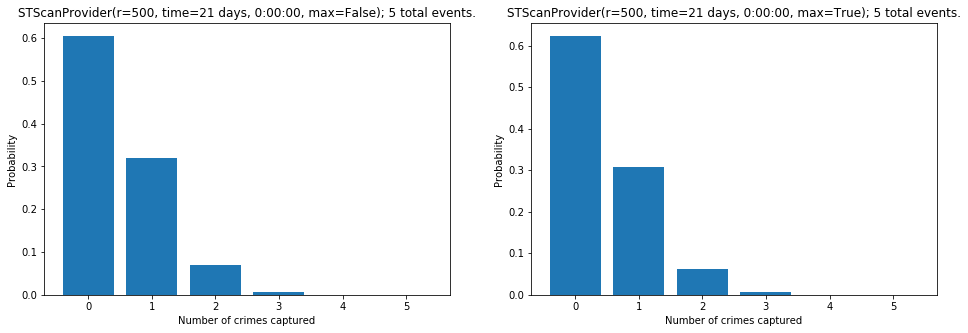

In [16]:
import scipy.special
import numpy as np

def BetaBinom(alpha,beta,n,k):
    """http://www.channelgrubb.com/blog/2015/2/27/beta-binomial-in-python"""
    part_1 = scipy.special.comb(n,k)
    part_2 = scipy.special.betaln(k+alpha,n-k+beta)
    part_3 = scipy.special.betaln(alpha,beta)
    
    result = (np.log(part_1) + part_2)- part_3
    
    return np.exp(result)

fig, axes = plt.subplots(ncols=len(betas), figsize=(16,5))

n = 5
for ax, key in zip(axes, betas):
    beta = betas[key][5]
    p = [BetaBinom(*beta.args,n,k) for k in range(0,n+1)]
    ax.bar(np.arange(n+1), p)
    ax.set(xlabel="Number of crimes captured", ylabel="Probability")
    ax.set_title("{}; {} total events.".format(key, n))

These plots show the probability of capturing $x$ events out of the 5 total events.  This sort of puts the difference in perspective-- it's pretty small!